# Aggregation and Grouping

An essential piece of analysis of large data is efficient summarization: computing aggregations like ``sum()``, ``mean()``, ``median()``, ``min()``, and ``max()``, in which a single number gives insight into the nature of a potentially large dataset.
In this section, we'll explore aggregations in Pandas, from simple operations akin to what we've seen on NumPy arrays, to more sophisticated operations based on the concept of a ``groupby``.

## Planets Data

Here we will use the Planets dataset, available via the [Seaborn package](http://seaborn.pydata.org/).
It gives information on planets that astronomers have discovered around other stars (known as *extrasolar planets* or *exoplanets* for short). It can be downloaded with a simple Seaborn command:

In [1]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [2]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [3]:
print("This has some details on the {} extrasolar planets discovered up to {}.".format(planets.shape[0],max(planets.year)))

This has some details on the 1035 extrasolar planets discovered up to 2014.


## Simple Aggregation in Pandas

Earlier, we explored some of the data aggregations available for NumPy arrays.
As with a one-dimensional NumPy array, for a Pandas ``Series`` the aggregates return a single value:

In [4]:
import numpy as np
import pandas as pd

rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

,0
0,0.374540
1,0.950714
2,0.731994
3,0.598658
4,0.156019


In [5]:
ser.sum()

2.811925491708157

In [6]:
ser.mean()

0.5623850983416314

For a ``DataFrame``, by default the aggregates return results within each column:

In [7]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [8]:
df.mean()

,0
A,0.477888
B,0.443420


By specifying the ``axis`` argument, you can instead aggregate within each row:

In [9]:
df.mean(axis='columns')

,0
0,0.088290
1,0.513997
2,0.849309
3,0.406727
4,0.444949


Pandas ``Series`` and ``DataFrame``s include a wide range of aggregations; in addition, there is a convenient method ``describe()`` that computes several common aggregates for each column and returns the result.
Let's use this on the Planets data, for now dropping rows with missing values:

In [10]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


This can be a useful way to begin understanding the overall properties of a dataset.
For example, we see in the ``year`` column that although exoplanets were discovered as far back as 1989, half of all known expolanets were not discovered until 2010 or after.
This is largely thanks to the *Kepler* mission, which is a space-based telescope specifically designed for finding eclipsing planets around other stars.

The following table summarizes some other built-in Pandas aggregations:

| Aggregation              | Description                     |
|--------------------------|---------------------------------|
| ``count()``              | Total number of items           |
| ``mean()``, ``median()`` | Mean and median                 |
| ``min()``, ``max()``     | Minimum and maximum             |
| ``std()``, ``var()``     | Standard deviation and variance |
| ``mad()``                | Mean absolute deviation (deprecated)         |
| ``prod()``               | Product of all items            |
| ``sum()``                | Sum of all items                |

These methods are both both ``DataFrame`` and ``Series`` objects.

## Your turn
Using the `planets` DataFrame try out the different aggregation functions:

In [11]:
# Your code goes here

To go deeper into the data, however, simple aggregates are often not enough.
The next level of data summarization is the ``groupby`` operation, which allows you to quickly and efficiently compute aggregates on subsets of data.

## GroupBy: Split, Apply, Combine

Simple aggregations can give you a flavor of your dataset, but often we would prefer to aggregate conditionally on some label or index: this is implemented in the so-called ``groupby`` operation.
The name "group by" comes from a command in the SQL database language, but it is perhaps more illuminative to think of it in the terms first coined by Hadley Wickham of Rstats fame: *split, apply, combine*.

### Split, apply, combine

A canonical example of this split-apply-combine operation, where the "apply" is a summation aggregation, is illustrated in this figure:

<img src="https://github.com/soltaniehha/Business-Analytics/blob/master/figs/06-02split-apply-combine.png?raw=true" width="800" align="center"/>

This makes clear what the ``groupby`` accomplishes:

- The *split* step involves breaking up and grouping a ``DataFrame`` depending on the value of the specified key.
- The *apply* step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
- The *combine* step merges the results of these operations into an output array.

While this could certainly be done manually using some combination of the masking, aggregation, and merging commands covered earlier, an important realization is that *the intermediate splits do not need to be explicitly instantiated*. Rather, the ``GroupBy`` can (often) do this in a single pass over the data, updating the sum, mean, count, min, or other aggregate for each group along the way.
The power of the ``GroupBy`` is that it abstracts away these steps: the user need not think about *how* the computation is done under the hood, but rather thinks about the *operation as a whole*.

As a concrete example, let's take a look at using Pandas for the computation shown in this diagram.
We'll start by creating the input ``DataFrame``:

In [12]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(1,7)})
df

,key,data
0,A,1
1,B,2
2,C,3
3,A,4
4,B,5
5,C,6


The most basic split-apply-combine operation can be computed with the ``groupby()`` method of ``DataFrame``s, passing the name of the desired key column:

In [13]:
df.groupby('key')

Notice that what is returned is not a set of ``DataFrame``s, but a ``DataFrameGroupBy`` object.
This object is where the magic is: you can think of it as a special view of the ``DataFrame``, which is poised to dig into the groups but does no actual computation until the aggregation is applied.
This "lazy evaluation" approach means that common aggregates can be implemented very efficiently in a way that is almost transparent to the user.

To produce a result, we can apply an aggregate to this ``DataFrameGroupBy`` object, which will perform the appropriate apply/combine steps to produce the desired result:

In [14]:
df.groupby('key').sum()

,data
key,
A,5
B,7
C,9


The ``sum()`` method is just one possibility here; you can apply virtually any common Pandas or NumPy aggregation function, as well as virtually any valid ``DataFrame`` operation, as we will see in the following discussion.

### The GroupBy object

The ``GroupBy`` object is a very flexible abstraction.
In many ways, you can simply treat it as if it's a collection of ``DataFrame``s, and it does the difficult things under the hood. Let's see some examples using the Planets data.

Perhaps the most important operations made available by a ``GroupBy`` are *aggregate*, *filter*, *transform*, and *apply*.
We'll discuss each of these more fully in the "Aggregate, Filter, Transform, Apply" section below, but before that let's introduce some of the other functionality that can be used with the basic ``GroupBy`` operation.

#### Column indexing

The ``GroupBy`` object supports column indexing in the same way as the ``DataFrame``, and returns a modified ``GroupBy`` object.
For example:

In [15]:
planets.groupby('method')

In [16]:
planets.groupby('method')['orbital_period']

Here we've selected a particular ``Series`` group from the original ``DataFrame`` group by reference to its column name.
As with the ``GroupBy`` object, no computation is done until we call some aggregate on the object:

In [17]:
planets.groupby('method')['orbital_period'].median()

,orbital_period
method,
Astrometry,631.180000
Eclipse Timing Variations,4343.500000
Imaging,27500.000000
Microlensing,3300.000000
Orbital Brightness Modulation,0.342887
Pulsar Timing,66.541900
Pulsation Timing Variations,1170.000000
Radial Velocity,360.200000
Transit,5.714932


This gives an idea of the general scale of orbital periods (in days) that each method is sensitive to.

#### Iteration over groups

The ``GroupBy`` object supports direct iteration over the groups, returning each group as a ``Series`` or ``DataFrame``:

In [18]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


This can be useful for doing certain things manually, though it is often much faster to use the built-in ``apply`` functionality, which we will discuss momentarily.

#### Dispatch methods

Through some Python class magic, any method not explicitly implemented by the ``GroupBy`` object will be passed through and called on the groups, whether they are ``DataFrame`` or ``Series`` objects.
For example, you can use the ``describe()`` method of ``DataFrame``s to perform a set of aggregations that describe each group in the data:

In [19]:
planets.groupby('method')['year'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
Astrometry,2.0,2011.500000,2.121320,2010.0,2010.75,2011.5,2012.25,2013.0
Eclipse Timing Variations,9.0,2010.000000,1.414214,2008.0,2009.00,2010.0,2011.00,2012.0
Imaging,38.0,2009.131579,2.781901,2004.0,2008.00,2009.0,2011.00,2013.0
Microlensing,23.0,2009.782609,2.859697,2004.0,2008.00,2010.0,2012.00,2013.0
Orbital Brightness Modulation,3.0,2011.666667,1.154701,2011.0,2011.00,2011.0,2012.00,2013.0
Pulsar Timing,5.0,1998.400000,8.384510,1992.0,1992.00,1994.0,2003.00,2011.0
Pulsation Timing Variations,1.0,2007.000000,NaN,2007.0,2007.00,2007.0,2007.00,2007.0
Radial Velocity,553.0,2007.518987,4.249052,1989.0,2005.00,2009.0,2011.00,2014.0
Transit,397.0,2011.236776,2.077867,2002.0,2010.00,2012.0,2013.00,2014.0


Looking at this table helps us to better understand the data: for example, the vast majority of planets have been discovered by the Radial Velocity and Transit methods, though the latter only became common (due to new, more accurate telescopes) in the last decade.
The newest methods seem to be Transit Timing Variation and Orbital Brightness Modulation, which were not used to discover a new planet until 2011.

Since `describe()` method returns a DataFrame we can apply the `sort_values()` method to sort based on one of the columns. For instance we can sort by min year to check out the methods based on their history:

In [20]:
planets.groupby('method')['year'].describe().sort_values('min')

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
Radial Velocity,553.0,2007.518987,4.249052,1989.0,2005.00,2009.0,2011.00,2014.0
Pulsar Timing,5.0,1998.400000,8.384510,1992.0,1992.00,1994.0,2003.00,2011.0
Transit,397.0,2011.236776,2.077867,2002.0,2010.00,2012.0,2013.00,2014.0
Imaging,38.0,2009.131579,2.781901,2004.0,2008.00,2009.0,2011.00,2013.0
Microlensing,23.0,2009.782609,2.859697,2004.0,2008.00,2010.0,2012.00,2013.0
Pulsation Timing Variations,1.0,2007.000000,NaN,2007.0,2007.00,2007.0,2007.00,2007.0
Eclipse Timing Variations,9.0,2010.000000,1.414214,2008.0,2009.00,2010.0,2011.00,2012.0
Astrometry,2.0,2011.500000,2.121320,2010.0,2010.75,2011.5,2012.25,2013.0
Orbital Brightness Modulation,3.0,2011.666667,1.154701,2011.0,2011.00,2011.0,2012.00,2013.0


This is just one example of the utility of dispatch methods.
Notice that they are applied *to each individual group*, and the results are then combined within ``GroupBy`` and returned.
Again, any valid ``DataFrame``/``Series`` method can be used on the corresponding ``GroupBy`` object, which allows for some very flexible and powerful operations!

### Aggregate, filter, transform, apply

The preceding discussion focused on aggregation for the combine operation, but there are more options available.
In particular, ``GroupBy`` objects have ``aggregate()``, ``filter()``, ``transform()``, and ``apply()`` methods that efficiently implement a variety of useful operations before combining the grouped data.

For the purpose of the following subsections, we'll use this ``DataFrame``:

In [21]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['Massachusetts', 'California', 'New York', 'Massachusetts', 'California', 'New York'],
                   'data1': range(1,7),
                   'data2': rng.randint(0, 10, 6)})
df

,key,data1,data2
0,Massachusetts,1,5
1,California,2,0
2,New York,3,3
3,Massachusetts,4,3
4,California,5,7
5,New York,6,9


#### Aggregation

We're now familiar with ``GroupBy`` aggregations with ``sum()``, ``median()``, and the like, but the ``aggregate()`` method allows for even more flexibility.
It can take a string, a function, or a list thereof, and compute all the aggregates at once.
Here is a quick example combining all these:

In [22]:
agg1 = df.groupby('key').aggregate(['min', np.median, max])
agg1

<ipython-input-22-d40562040e50>:1: FutureWarning: The provided callable <function median at 0x7fd1e5547400> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  agg1 = df.groupby('key').aggregate(['min', np.median, max])
<ipython-input-22-d40562040e50>:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  agg1 = df.groupby('key').aggregate(['min', np.median, max])


data1            data2           
                min median max   min median max
key                                            
California        2    3.5   5     0    3.5   7
Massachusetts     1    2.5   4     3    4.0   5
New York          3    4.5   6     3    6.0   9

The result is a multi-index DataFrame. We can access subsets of this DataFrame by a format like this:

In [23]:
agg1['data1']

,min,median,max
key,,,
California,2,3.5,5
Massachusetts,1,2.5,4
New York,3,4.5,6


In [24]:
agg1['data1']['median']

,median
key,
California,3.5
Massachusetts,2.5
New York,4.5


Another useful pattern is to pass a dictionary mapping column names to operations to be applied on that column:

In [25]:
df.groupby('key').agg({'data1': 'min',
                             'data2': 'max'})

,data1,data2
key,,
California,2,7
Massachusetts,1,5
New York,3,9


#### Filtering

A filtering operation allows you to drop data based on the group properties.
For example, we might want to keep all groups in which the average is larger than some critical value:

In [26]:
df2 = df[['key', 'data2']]
df2

,key,data2
0,Massachusetts,5
1,California,0
2,New York,3
3,Massachusetts,3
4,California,7
5,New York,9


In [27]:
df2.groupby('key').mean()

,data2
key,
California,3.5
Massachusetts,4.0
New York,6.0


In [28]:
def filter_func(x):
    return x['data2'].mean() > 5

df2.groupby('key').filter(filter_func)

,key,data2
2,New York,3
5,New York,9


The filter function should return a Boolean value specifying whether the group passes the filtering. Here because group California and Massachusetts do not have an average greater than 5, they are dropped from the result.

#### Transformation

While aggregation must return a reduced version of the data, transformation can return some transformed version of the full data to recombine.
For such a transformation, the output is the same shape as the input.
A common example is to center the data by subtracting the group-wise mean:

In [29]:
df2.groupby('key').transform(lambda x: x - x.mean())

,data2
0,1.0
1,-3.5
2,-3.0
3,-1.0
4,3.5
5,3.0


#### The apply() method

The ``apply()`` method lets you apply an arbitrary function to the group results.
The function should take a ``DataFrame``, and return either a Pandas object (e.g., ``DataFrame``, ``Series``) or a scalar; the combine operation will be tailored to the type of output returned.

For example, here is an ``apply()`` that normalizes the first column by the sum of the second:

In [30]:
df

,key,data1,data2
0,Massachusetts,1,5
1,California,2,0
2,New York,3,3
3,Massachusetts,4,3
4,California,5,7
5,New York,6,9


In [31]:
def norm_by_data2(x):
    # x is a DataFrame of group values
    x['data1'] /= x['data2'].sum()
    return x

df.groupby('key').apply(norm_by_data2)

key     data1  data2
key                                            
California    1     California  0.285714      0
              4     California  0.714286      7
Massachusetts 0  Massachusetts  0.125000      5
              3  Massachusetts  0.500000      3
New York      2       New York  0.250000      3
              5       New York  0.500000      9

``apply()`` within a ``GroupBy`` is quite flexible: the only criterion is that the function takes a ``DataFrame`` and returns a Pandas object or scalar; what you do in the middle is up to you!

### `transform()` vs. `apply()`

`transform()` works on just one Series at a time and apply works on the entire DataFrame at once. For instance, in the example below we see that when the function needs to access more than one column the `transform` method fails:

In [32]:
df

,key,data1,data2
0,Massachusetts,1,5
1,California,2,0
2,New York,3,3
3,Massachusetts,4,3
4,California,5,7
5,New York,6,9


In [33]:
def subtract_two(x):
    return x['data1'] - x['data2']

In [34]:
df.groupby('key').transform(subtract_two)

KeyError: 'data1'

While `apply()` will give us the answer:

In [35]:
df.groupby('key').apply(subtract_two)

key             
California     1    2
               4   -2
Massachusetts  0   -4
               3    1
New York       2    0
               5   -3
dtype: int64

### Specifying the split key

In the simple examples presented before, we split the ``DataFrame`` on a single column name.
This is just one of many options by which the groups can be defined, and we'll go through some other options for group specification here.

#### A list, array, series, or index providing the grouping keys

The key can be any series or list with a length matching that of the ``DataFrame``. For example:

In [36]:
df

,key,data1,data2
0,Massachusetts,1,5
1,California,2,0
2,New York,3,3
3,Massachusetts,4,3
4,California,5,7
5,New York,6,9


In [37]:
L = [0, 1, 0, 1, 2, 0]
df.groupby(L).sum()

,key,data1,data2
0,MassachusettsNew YorkNew York,10,17
1,CaliforniaMassachusetts,6,3
2,California,5,7


#### A dictionary or series mapping index to group

Another method is to provide a dictionary that maps index values to the group keys:

In [38]:
df3 = df.set_index('key')
df3

,data1,data2
key,,
Massachusetts,1,5
California,2,0
New York,3,3
Massachusetts,4,3
California,5,7
New York,6,9


In [39]:
mapping = {'Massachusetts': 'Eastcost', 'California': 'Westcost', 'New York': 'Eastcost'}
df3.groupby(mapping).sum()

,data1,data2
key,,
Eastcost,14,20
Westcost,7,7


#### Any Python function

Similar to mapping, you can pass any Python function that will input the index value and output the group:

In [40]:
df3.groupby(str.lower).mean()

,data1,data2
key,,
california,3.5,3.5
massachusetts,2.5,4.0
new york,4.5,6.0


#### A list of valid keys

Further, any of the preceding key choices can be combined to group on a multi-index:

In [41]:
df3.groupby([str.lower, mapping]).mean()

,,data1,data2
key,key,,
california,Westcost,3.5,3.5
massachusetts,Eastcost,2.5,4.0
new york,Eastcost,4.5,6.0


### Grouping example

As an example of this, in a couple lines of Python code we can put all these together and count discovered planets by method and by decade:

In [42]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

year,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0


This shows the power of combining many of the operations we've discussed up to this point when looking at realistic datasets.
We immediately gain a coarse understanding of when and how planets have been discovered over the past several decades!

Here I would suggest digging into these few lines of code, and evaluating the individual steps to make sure you understand exactly what they are doing to the result.
It's certainly a somewhat complicated example, but understanding these pieces will give you the means to similarly explore your own data.

Let's visualize this summary as a heatmap:

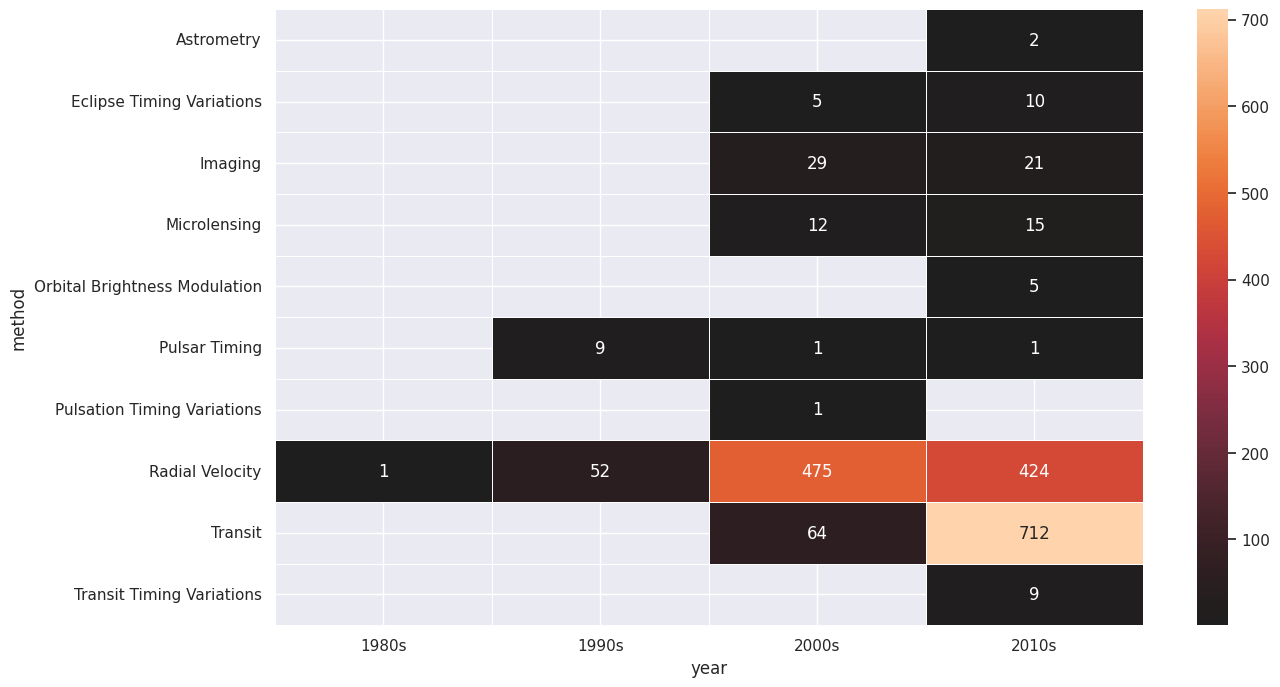

In [44]:
summary = planets.groupby(['method', decade])['number'].sum().unstack()
import seaborn as sns
sns.set(rc={'figure.figsize':(14,8)})
sns.heatmap(summary, center=0, annot=True, linewidths=.5, fmt='.0f');